In [18]:
import graph_tool as gt
import torch
import pickle
from src.diffusion_model_discrete import DiscreteDenoisingDiffusion
from sample import get_model_sbm
from src.diffusion import diffusion_utils
import networkx as nx
import matplotlib.pyplot as plt

In [2]:
model = get_model_sbm()


(ipykernel_launcher.py:19026): Gtk-WARNING **: 14:44:27.470: Locale not supported by C library.
	Using the fallback 'C' locale.
<frozen importlib._bootstrap>:228: RuntimeWarning: to-Python converter for std::pair<double, double> already registered; second conversion method ignored.
/home/renyi/anaconda3/envs/digress/lib/python3.9/site-packages/torch/nn/init.py:405: UserWarning: Initializing zero-element tensors is a no-op
  warnings.warn("Initializing zero-element tensors is a no-op")


Marginal distribution of the classes: tensor([1.]) for nodes, tensor([0.9156, 0.0844]) for edges


In [11]:
batch_size = 1
n_nodes = model.node_dist.sample_n(batch_size, model.device)
print(n_nodes)

tensor([58], device='cuda:0')


In [12]:
node_mask = torch.ones((batch_size, n_nodes.item()), device=model.device, dtype=torch.bool)
print(node_mask.shape)


torch.Size([1, 58])


In [13]:
z_T = diffusion_utils.sample_discrete_feature_noise(limit_dist=model.limit_dist, node_mask=node_mask)
X, E, y = z_T.X, z_T.E, z_T.y
print(E.size())

torch.Size([1, 58, 58, 2])


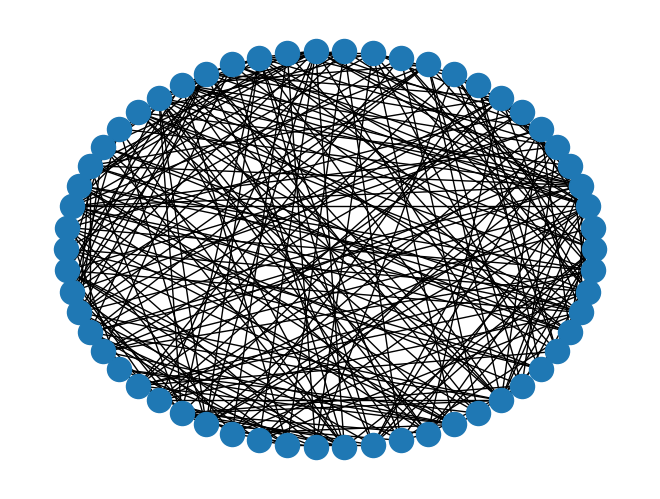

In [22]:
def visualize_graph(E):
    adj_matrix = torch.argmax(E, dim=-1).squeeze(0).cpu().numpy()
    G = nx.from_numpy_matrix(adj_matrix)
    pos = nx.circular_layout(G)
    nx.draw(G, pos, with_labels=False)
visualize_graph(E)

In [25]:
def visualize_graph_batch(l):
    plt.figure(figsize=(30, 6 * (len(l) // 5 + 1))) 
    for i, (step, E) in enumerate(l):
        plt.subplot(len(l) // 5 + 1, 5, i + 1)
        adj_matrix = torch.argmax(E, dim=-1).squeeze(0).cpu().numpy()
        G = nx.from_numpy_matrix(adj_matrix)
        pos = nx.circular_layout(G)
        nx.draw(G, pos, with_labels=False)
        plt.title(f'Step {step}')
    plt.tight_layout() 
    plt.show() 

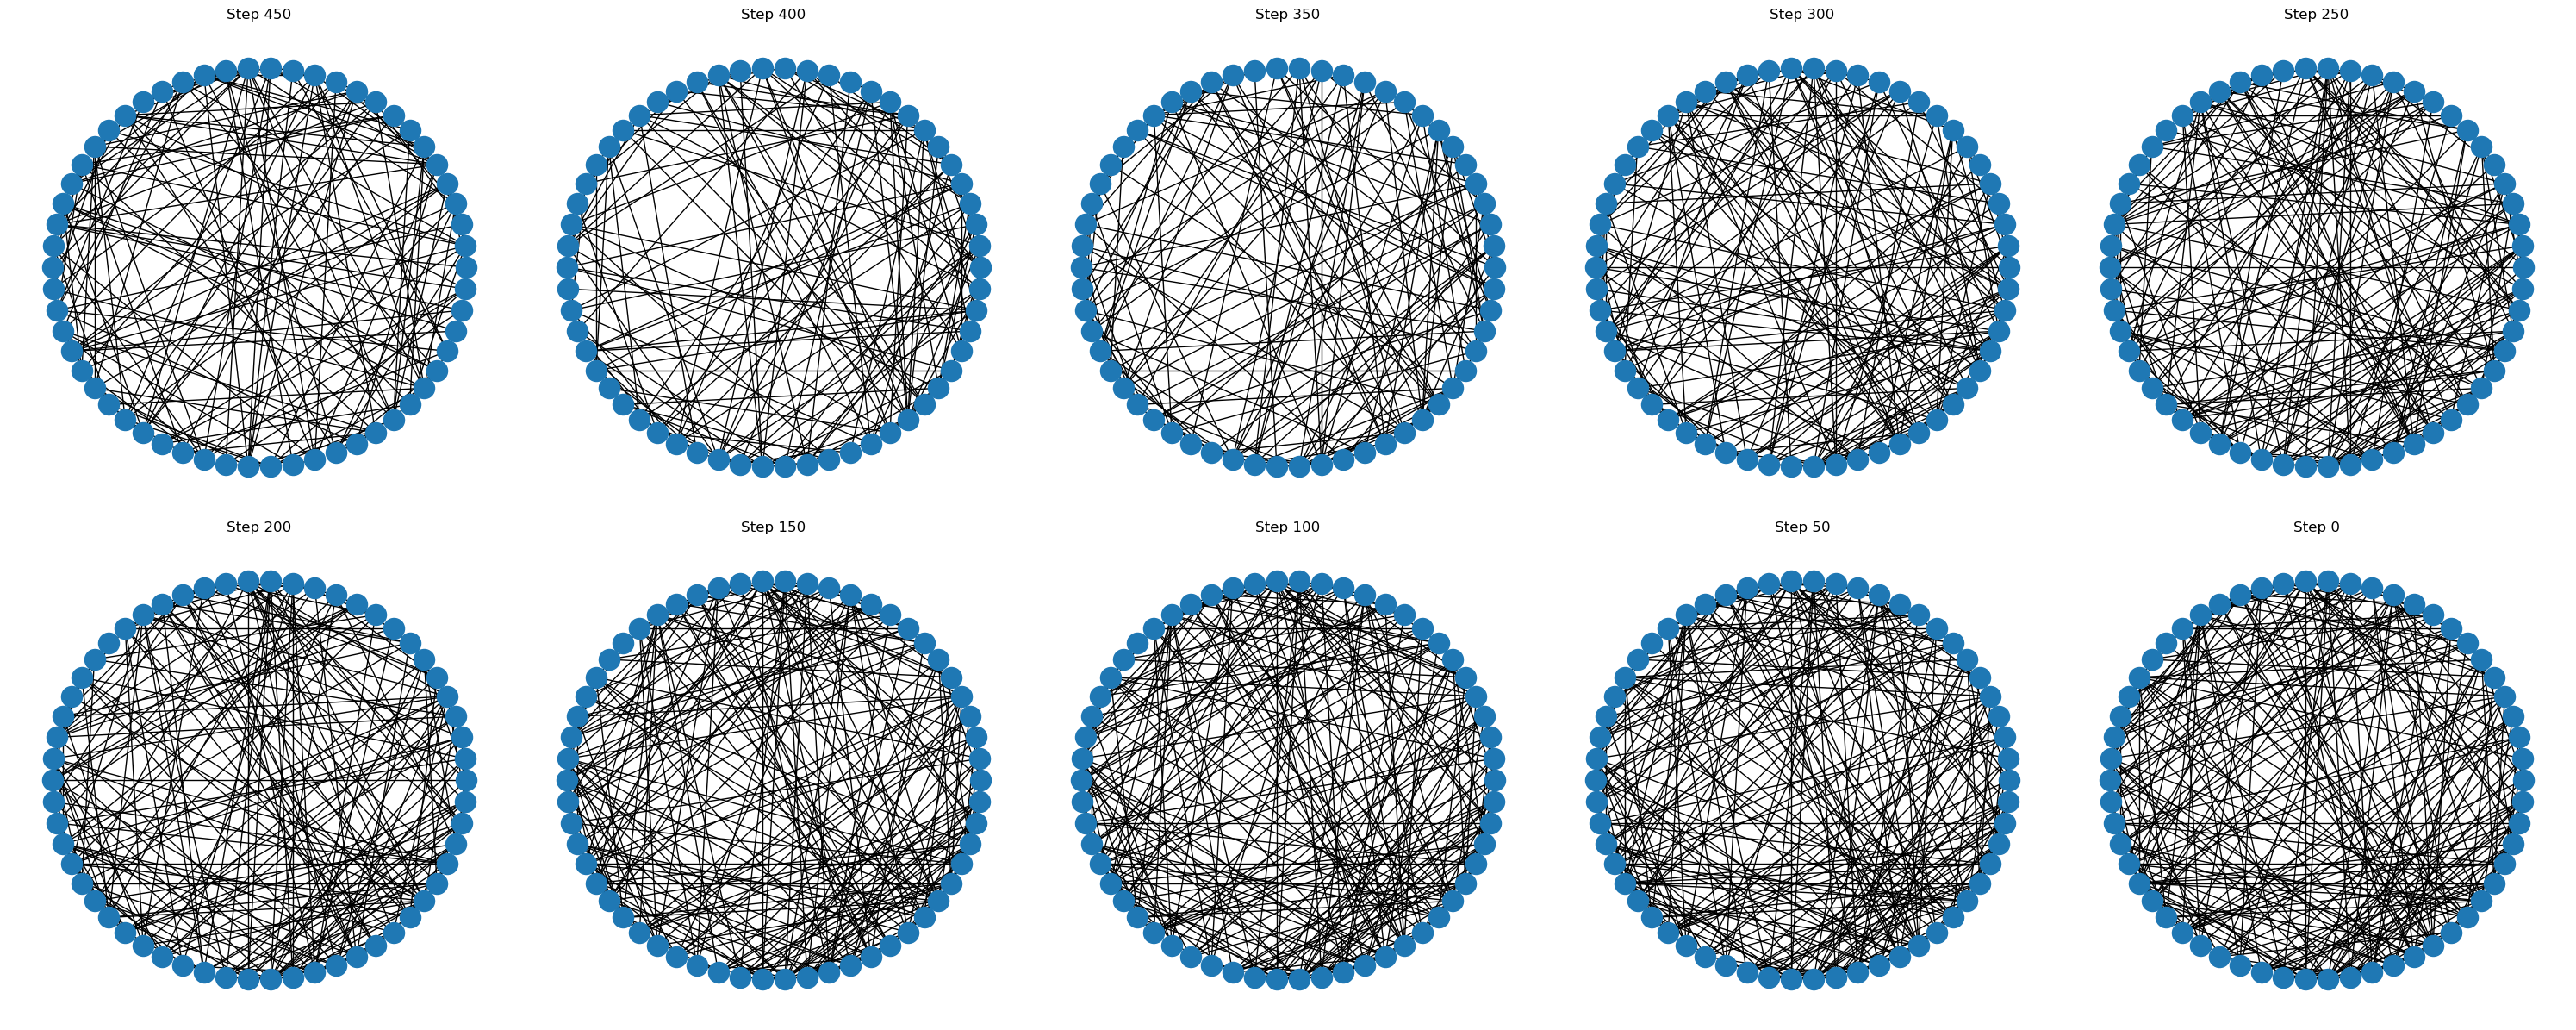

In [27]:
l = []
for s_int in reversed(range(0, model.T)):
    s_array = s_int * torch.ones((batch_size, 1)).type_as(y)
    t_array = s_array + 1
    s_norm = s_array / model.T
    t_norm = t_array / model.T
    sampled_s, _ = model.sample_p_zs_given_zt(s_norm, t_norm, X, E, y, node_mask)
    X, E, y = sampled_s.X, sampled_s.E, sampled_s.y
    if s_int % 50 == 0:
        l.append((s_int, E))
        
visualize_graph_batch(l)